# Notebook to evaluate the activity model

This notebook is designed as an evaluation notebook.

In [1]:
%matplotlib notebook
import matplotlib as mpl
import matplotlib.pyplot as plt
import csv
import time
import os
import ants
import pandas as pd
import statsmodels.api as smapi
import numpy as np
from nibabel import load as load_nii
from nibabel import Nifti1Image
from skimage.filters import threshold_otsu
from skimage.measure import label as bwlabeln
from scipy.ndimage.morphology import binary_erosion
from scipy.ndimage.morphology import binary_dilation
from scipy.ndimage.morphology import binary_closing
from scipy.ndimage.morphology import binary_fill_holes
from scipy.stats import ttest_rel, normaltest
from scipy.stats import spearmanr, kendalltau
from shutil import copyfile
import seaborn as sns

## Utility functions
### Statistics

In [2]:
def plot_correlation(metrics, network, lowess=False):
    model_vols = [m[5] for m in metrics['positive'] if m[1] == network]
    manual_vols = [m[6] for m in metrics['positive'] if m[1] == network]
    model_lesions = [m[10] for m in metrics['positive'] if m[1] == network]
    manual_lesions = [m[11] for m in metrics['positive'] if m[1] == network]
    array = [
        [
            (m[6] - np.mean(manual_vols)) / np.std(manual_vols),
            (m[5] - np.mean(model_vols)) / np.std(model_vols),
            'Volume'
        ]
        for m in metrics['positive'] if m[1] == network
    ] + [
        [
            (m[11] - np.mean(manual_lesions)) / np.std(manual_lesions),
            (m[10] - np.mean(model_lesions)) / np.std(model_lesions),
            'Lesions'
        ]
        for m in metrics['positive'] if m[1] == network
    ]

    columns = [
        'Manual',
        'Model',
        'Value per patient'
    ]
    dataframe = pd.DataFrame(array, columns=columns)

    snd_handle = sns.lmplot(
        x='Model', y='Manual', data=dataframe, hue='Value per patient',
        ci=68, truncate=False, lowess=lowess, robust=(not lowess)
    ) 
    
    lesions_dataframe = dataframe[dataframe['Value per patient'] == 'Lesions']
    x = lesions_dataframe['Model'].to_numpy()
    y = lesions_dataframe['Manual'].to_numpy()
    
    x[np.isnan(x)] = 0
    y[np.isnan(y)] = 0
    
    results_lesions = smapi.OLS(y, smapi.add_constant(x)).fit()
    spr_lesions, _ = spearmanr(x, y)
    
    volume_dataframe = dataframe[dataframe['Value per patient'] == 'Volume']
    x = volume_dataframe['Model'].to_numpy()
    y = volume_dataframe['Manual'].to_numpy()
    
    x[np.isnan(x)] = 0
    y[np.isnan(y)] = 0
    
    results_volume = smapi.OLS(y, smapi.add_constant(x)).fit()
    spr_volume, _ = spearmanr(x, y)

    if lowess:
        plt.title(
            u'{:} Lesions [\u03C1 = {:5.3f}] / Volume [\u03C1 = {:5.3f}]'.format(
                network, spr_lesions, spr_volume     
            )
        )
    else:
        plt.title(
            u'{:} Lesions [R\u00b2 = {:5.3f}] / Volume [R\u00b2 = {:5.3f}]'.format(
                network,
                results_lesions.rsquared,
                results_volume.rsquared     
            )
        )
    snd_handle.fig.subplots_adjust(top=.95, bottom=.1)
    
def print_correlation(metrics, network):
    
    x = [m[10] for m in metrics['positive'] if m[1] == network]
    y = [m[11] for m in metrics['positive'] if m[1] == network]
    
    x[np.isnan(x)] = 0
    y[np.isnan(y)] = 0
    
    results_lesions = smapi.OLS(y, smapi.add_constant(x)).fit()
    spr_lesions, _ = spearmanr(x, y)
    
    x = [m[5] for m in metrics['positive'] if m[1] == network]
    y = [m[6] for m in metrics['positive'] if m[1] == network]
    
    x[np.isnan(x)] = 0
    y[np.isnan(y)] = 0
    
    results_volume = smapi.OLS(y, smapi.add_constant(x)).fit()
    spr_volume, _ = spearmanr(x, y)

    if lowess:
        plt.title(
            u'{:} Lesions [\u03C1 = {:5.3f}] / Volume [\u03C1 = {:5.3f}]'.format(
                network, spr_lesions, spr_volume     
            )
        )
    else:
        plt.title(
            u'{:} Lesions [R\u00b2 = {:5.3f}] / Volume [R\u00b2 = {:5.3f}]'.format(
                network,
                results_lesions.rsquared,
                results_volume.rsquared     
            )
        )

### Others

In [3]:
def get_int(string):
    """
    Function to get the int number contained in a string. If there are more
    than one int number (or there is a floating point number), this function
    will concatenate all digits and return an int, anyways.
    :param string: String that contains an int number
    :return: int number
    """
    return int(''.join(filter(str.isdigit, string)))


def get_dirs(path):
    """
    Function to get the folder name of the patients given a path.
    :param path: Folder where the patients should be located.
    :return: List of patient names.
    """
    # All patients (full path)
    patient_paths = sorted(
        filter(
            lambda d: os.path.isdir(os.path.join(path, d)),
            os.listdir(path)
        )
    )
    # Patients used during training
    return patient_paths

## Data loading

In [4]:
path = '/media/transcend/MSReports/Longitudinal/MICCAI_Challenge2021/training/'
cases = [
    p for p in sorted(os.listdir(path))
    if os.path.isdir(os.path.join(path, p))
]
print(cases)

['013', '015', '016', '018', '019', '020', '021', '024', '026', '027', '029', '030', '032', '035', '037', '039', '043', '047', '048', '049', '051', '052', '057', '061', '068', '069', '070', '074', '077', '083', '084', '088', '089', '090', '091', '094', '095', '096', '099', '100']


In [5]:
positive_cases = []
negative_cases = []
for p in cases:
    p_path = os.path.join(path, p)
    print('\033[KChecking {:}'.format(p_path), end='\r')
    gt_bool = load_nii(
        os.path.join(p_path, 'ground_truth.nii.gz')
    ).get_fdata().astype(bool)
    if np.sum(gt_bool) > 0:
        positive_cases.append(p)
    else:
        negative_cases.append(p)
print('Positive cases', positive_cases)
print('Negative cases', negative_cases)

Positive cases ['013', '016', '018', '020', '021', '024', '026', '027', '029', '030', '032', '035', '037', '039', '043', '047', '048', '057', '061', '069', '074', '077', '083', '088', '091', '094', '095', '099', '100']
Negative cases ['015', '019', '049', '051', '052', '068', '070', '084', '089', '090', '096']


## Metrics

### Loading and data preparation

In [6]:
all_metrics = {
    'positive': [],
    'negative': []
}
manual_vols = []
model_vols = []
manual_lesions = []
model_lesions = []
positive_metrics = [
    'Patient', 'Network',
    'TPF (V)', 'FPF (V)', 'DSC', 'TP (V)', 'V','GT (V)',
    'TPF (D)', 'FPF (D)', 'TP (D)', 'D', 'GT (D)', 'TP (C)'
]
negative_metrics = [
    'Patient', 'Network',
    'FP (V)', 'FP (D)', 'FP (C)'
]
training_labels = {
    '': 'Baseline',
    '_ft': 'Fine-tuning',
    '_ft-freeze': 'Fine-tuning (frozen)',
#     '_init': 'Trained (private)',
    '_xval': 'Trained',
    '_init': 'Pretrained (private)',
    '_prexval': 'Pretrained',
    '_final': 'Final',
}
with open(
        os.path.join(path, 'activity_metrics.csv'), 'w'
) as csvfile:
    evalwriter = csv.writer(csvfile)
    evalwriter.writerow(positive_metrics)
    for p in cases:
        p_path = os.path.join(path, p)
        print('\033[KChecking {:}'.format(p_path), end='\r')
        gt_bool = load_nii(
            os.path.join(p_path, 'ground_truth.nii.gz')
        ).get_fdata().astype(bool)
        gt_lab = bwlabeln(gt_bool)
        gt_v = np.sum(gt_bool)
        gt_d = len(np.unique(gt_lab[gt_lab > 0]))
        gtc = gt_v > 0
        
        for tr_key, tr_value in training_labels.items():
            auto_name = os.path.join(
                p_path, 'positive_activity{:}.nii.gz'.format(tr_key)
            )
            auto_bool = load_nii(auto_name).get_fdata().astype(bool)
            auto_lab = bwlabeln(auto_bool)
            auto_labs = np.unique(auto_lab)
            
            v = np.sum(auto_bool)

            # Positive cases
            if gtc:
                # Some intermediate steps.
                overlap = np.logical_and(gt_bool, auto_bool)
                nonoverlap = np.logical_and(np.logical_not(gt_bool), auto_bool)
                               
                # Pretty common and normal voxelwise / segmentation metrics.
                sum_v = v + gt_v
                
                tp_v = np.sum(overlap)
                tpf_v = tp_v / gt_v if gt_v > 0 else 0
                fp_v = np.sum(nonoverlap)
                fpf_v = fp_v / v if v > 0 else 0
                dsc = 2 * tp_v / sum_v if sum_v > 0 else 0

                # And finally a few regionwise / detection metrics.
                tp_labs = np.unique(gt_lab[auto_bool])
                notfp_labs = np.unique(auto_lab[gt_bool])
                fp_mask = np.logical_not(np.isin(auto_lab, notfp_labs))
                fp_labs = np.unique(auto_lab[fp_mask])
                tp = len(tp_labs[tp_labs > 0])
                tp_d = len(tp_labs[tp_labs > 0])
                fp = len(fp_labs[fp_labs > 0])
                tpf_d = 100 * tp / gt_d if gt_d > 0 else 0
                d = len(np.unique(auto_lab[auto_lab > 0]))
                fpf_d = 100 * fp / d if d > 0 else 0

                tpc = v > 0

                all_metrics['positive'].append([
                    p, tr_value, tpf_v, fpf_v, dsc, tp_v, v, gt_v,
                    tpf_d, fpf_d, tp_d, d, gt_d, tpc
                ])
                evalwriter.writerow([
                    p, tr_value, tpf_v, fpf_v, dsc, tp_v, v, gt_v,
                    tpf_d, fpf_d, tp_d, d, gt_d, tpc
                ])
            else:
                # And finally a few regionwise / detection metrics.
                fp_d = len(auto_labs[auto_labs > 0])
                fp_c = fp_d > 0
                fp_v = v

                all_metrics['negative'].append([
                    p, tr_value, fp_v, fp_d, fp_c
                ])

### Patient-based metrics

In [7]:
pd.DataFrame(all_metrics['positive'], columns=positive_metrics)

,Patient,Network,TPF (V),FPF (V),DSC,TP (V),V,GT (V),TPF (D),FPF (D),TP (D),D,GT (D),TP (C)
0,013,Baseline,0.650000,0.587302,0.504854,26,63,40,100.0,50.000000,1,2,1,True
1,013,Fine-tuning,0.750000,0.655172,0.472441,30,87,40,100.0,50.000000,1,2,1,True
2,013,Fine-tuning (frozen),0.825000,0.736000,0.400000,33,125,40,100.0,80.000000,1,5,1,True
3,013,Trained,0.750000,0.651163,0.476190,30,86,40,100.0,50.000000,1,2,1,True
4,013,Pretrained (private),0.525000,0.603774,0.451613,21,53,40,100.0,50.000000,1,2,1,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
198,100,Fine-tuning (frozen),0.731278,0.161616,0.781176,664,792,908,100.0,77.777778,2,9,2,True
199,100,Trained,0.577093,0.059246,0.715358,524,557,908,100.0,50.000000,2,4,2,True
200,100,Pretrained (private),0.534141,0.035785,0.687456,485,503,908,100.0,50.000000,2,4,2,True
201,100,Pretrained,0.483480,0.116700,0.624911,439,497,908,100.0,33.333333,2,3,2,True


In [8]:
positive_df = pd.DataFrame(all_metrics['positive'], columns=positive_metrics)
positive_df[positive_df['DSC'] < 0.6]

,Patient,Network,TPF (V),FPF (V),DSC,TP (V),V,GT (V),TPF (D),FPF (D),TP (D),D,GT (D),TP (C)
0,013,Baseline,0.650000,0.587302,0.504854,26,63,40,100.0,50.000000,1,2,1,True
1,013,Fine-tuning,0.750000,0.655172,0.472441,30,87,40,100.0,50.000000,1,2,1,True
2,013,Fine-tuning (frozen),0.825000,0.736000,0.400000,33,125,40,100.0,80.000000,1,5,1,True
3,013,Trained,0.750000,0.651163,0.476190,30,86,40,100.0,50.000000,1,2,1,True
4,013,Pretrained (private),0.525000,0.603774,0.451613,21,53,40,100.0,50.000000,1,2,1,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
181,094,Final,0.638298,0.826192,0.273219,1590,9148,2491,100.0,89.655172,5,58,5,True
189,099,Baseline,0.301205,0.000000,0.462963,25,25,83,100.0,0.000000,1,1,1,True
191,099,Fine-tuning (frozen),0.626506,0.469388,0.574586,52,98,83,100.0,66.666667,1,3,1,True
192,099,Trained,0.072289,0.000000,0.134831,6,6,83,100.0,0.000000,1,1,1,True


In [37]:
positive_df[(positive_df['Network'] == 'Final') | (positive_df['Network'] == 'Baseline')]
trained_df = positive_df[positive_df['Network'] == 'Final']
baseline_df = positive_df[positive_df['Network'] == 'Baseline']

trained_patients = []
baseline_patients = []
bad_patients = []
fp_patients = []

for (trained_idx, trained_row), (baseline_idx, baseline_row) in zip(trained_df.iterrows(), baseline_df.iterrows()):
    if trained_row['DSC'] > baseline_row['DSC']:
        trained_patients.append(trained_row['Patient'])
    else:
        baseline_patients.append(trained_row['Patient'])
    if trained_row['DSC'] < 0.6:
        bad_patients.append(trained_row['Patient'])
    elif trained_row['FPF (D)'] > 20:
            bad_patients.append(trained_row['Patient'])
    if trained_row['FPF (D)'] > 20:
        fp_patients.append(trained_row['Patient'])

In [38]:
trained_df[trained_df['Patient'].isin(bad_patients)]

,Patient,Network,TPF (V),FPF (V),DSC,TP (V),V,GT (V),TPF (D),FPF (D),TP (D),D,GT (D),TP (C)
6,013,Final,0.500000,0.600000,0.444444,20,50,40,100.000000,50.000000,1,2,1,True
13,016,Final,0.714670,0.310390,0.701917,531,770,743,83.333333,28.571429,5,7,6,True
20,018,Final,0.500000,0.310606,0.579618,182,264,364,100.000000,60.000000,2,5,2,True
27,020,Final,0.507463,0.585366,0.456376,102,246,201,100.000000,83.333333,1,6,1,True
34,021,Final,0.724293,0.349859,0.685217,1613,2481,2227,100.000000,50.000000,4,8,4,True
48,026,Final,0.276596,0.103448,0.422764,104,116,376,44.444444,0.000000,4,4,9,True
62,029,Final,0.000000,0.000000,0.000000,0,0,802,0.000000,0.000000,0,0,2,False
69,030,Final,0.747518,0.232897,0.757184,527,687,705,100.000000,57.142857,3,7,3,True
76,032,Final,0.000000,1.000000,0.000000,0,14,53,0.000000,100.000000,0,1,1,True
83,035,Final,0.730013,0.489927,0.600539,557,1092,763,100.000000,73.333333,4,15,4,True


In [35]:
trained_df[trained_df['Patient'].isin(fp_patients)]

,Patient,Network,TPF (V),FPF (V),DSC,TP (V),V,GT (V),TPF (D),FPF (D),TP (D),D,GT (D),TP (C)
6,013,Final,0.500000,0.600000,0.444444,20,50,40,100.000000,50.000000,1,2,1,True
13,016,Final,0.714670,0.310390,0.701917,531,770,743,83.333333,28.571429,5,7,6,True
20,018,Final,0.500000,0.310606,0.579618,182,264,364,100.000000,60.000000,2,5,2,True
27,020,Final,0.507463,0.585366,0.456376,102,246,201,100.000000,83.333333,1,6,1,True
34,021,Final,0.724293,0.349859,0.685217,1613,2481,2227,100.000000,50.000000,4,8,4,True
69,030,Final,0.747518,0.232897,0.757184,527,687,705,100.000000,57.142857,3,7,3,True
76,032,Final,0.000000,1.000000,0.000000,0,14,53,0.000000,100.000000,0,1,1,True
83,035,Final,0.730013,0.489927,0.600539,557,1092,763,100.000000,73.333333,4,15,4,True
90,037,Final,0.952381,0.761905,0.380952,20,84,21,100.000000,80.000000,1,5,1,True
97,039,Final,0.385667,0.042609,0.549841,4741,4952,12293,76.923077,21.428571,10,14,13,True


In [26]:
trained_df[trained_df['Patient'].isin(trained_patients)]

,Patient,Network,TPF (V),FPF (V),DSC,TP (V),V,GT (V),TPF (D),FPF (D),TP (D),D,GT (D),TP (C)
20,018,Final,0.500000,0.310606,0.579618,182,264,364,100.000000,60.000000,2,5,2,True
34,021,Final,0.724293,0.349859,0.685217,1613,2481,2227,100.000000,50.000000,4,8,4,True
41,024,Final,0.783784,0.124006,0.827327,551,629,703,100.000000,14.285714,6,7,6,True
55,027,Final,0.721435,0.042607,0.822833,764,798,1059,100.000000,20.000000,4,5,4,True
69,030,Final,0.747518,0.232897,0.757184,527,687,705,100.000000,57.142857,3,7,3,True
97,039,Final,0.385667,0.042609,0.549841,4741,4952,12293,76.923077,21.428571,10,14,13,True
104,043,Final,0.211293,0.241830,0.330484,116,153,549,50.000000,33.333333,2,3,4,True
118,048,Final,0.728873,0.046083,0.826347,207,217,284,100.000000,0.000000,1,1,1,True
125,057,Final,0.535501,0.142361,0.659326,988,1152,1845,93.750000,25.000000,15,20,16,True
132,061,Final,0.659544,0.337941,0.660799,1389,2098,2106,83.333333,47.058824,10,17,12,True


In [27]:
baseline_df[~baseline_df['Patient'].isin(baseline_patients)]

,Patient,Network,TPF (V),FPF (V),DSC,TP (V),V,GT (V),TPF (D),FPF (D),TP (D),D,GT (D),TP (C)
14,018,Baseline,0.049451,0.000000,0.094241,18,18,364,50.000000,0.000000,1,1,2,True
28,021,Baseline,0.612034,0.231680,0.681330,1363,1774,2227,100.000000,33.333333,4,6,4,True
35,024,Baseline,0.681366,0.064453,0.788477,479,512,703,83.333333,0.000000,5,5,6,True
49,027,Baseline,0.521246,0.029877,0.678133,552,569,1059,100.000000,0.000000,4,4,4,True
63,030,Baseline,0.693617,0.199673,0.743161,489,611,705,100.000000,50.000000,3,6,3,True
91,039,Baseline,0.285447,0.025548,0.441550,3509,3601,12293,69.230769,0.000000,9,12,13,True
98,043,Baseline,0.200364,0.320988,0.309423,110,162,549,25.000000,50.000000,1,2,4,True
112,048,Baseline,0.700704,0.074419,0.797595,199,215,284,100.000000,0.000000,1,1,1,True
119,057,Baseline,0.275339,0.086331,0.423157,508,556,1845,62.500000,9.090909,10,11,16,True
126,061,Baseline,0.308167,0.347739,0.418575,649,995,2106,66.666667,46.153846,8,13,12,True


In [28]:
trained_df[~trained_df['Patient'].isin(trained_patients)]

,Patient,Network,TPF (V),FPF (V),DSC,TP (V),V,GT (V),TPF (D),FPF (D),TP (D),D,GT (D),TP (C)
6,013,Final,0.500000,0.600000,0.444444,20,50,40,100.000000,50.000000,1,2,1,True
13,016,Final,0.714670,0.310390,0.701917,531,770,743,83.333333,28.571429,5,7,6,True
27,020,Final,0.507463,0.585366,0.456376,102,246,201,100.000000,83.333333,1,6,1,True
48,026,Final,0.276596,0.103448,0.422764,104,116,376,44.444444,0.000000,4,4,9,True
62,029,Final,0.000000,0.000000,0.000000,0,0,802,0.000000,0.000000,0,0,2,False
76,032,Final,0.000000,1.000000,0.000000,0,14,53,0.000000,100.000000,0,1,1,True
83,035,Final,0.730013,0.489927,0.600539,557,1092,763,100.000000,73.333333,4,15,4,True
90,037,Final,0.952381,0.761905,0.380952,20,84,21,100.000000,80.000000,1,5,1,True
111,047,Final,0.116667,0.977199,0.038147,7,307,60,100.000000,85.714286,1,7,1,True
146,074,Final,0.752475,0.229493,0.761384,836,1085,1111,88.888889,42.857143,8,14,9,True


In [29]:
baseline_df[baseline_df['Patient'].isin(baseline_patients)]

,Patient,Network,TPF (V),FPF (V),DSC,TP (V),V,GT (V),TPF (D),FPF (D),TP (D),D,GT (D),TP (C)
0,013,Baseline,0.650000,0.587302,0.504854,26,63,40,100.000000,50.000000,1,2,1,True
7,016,Baseline,0.631225,0.078585,0.749201,469,509,743,83.333333,0.000000,5,5,6,True
21,020,Baseline,0.522388,0.447368,0.537084,105,190,201,100.000000,50.000000,1,2,1,True
42,026,Baseline,0.385638,0.152047,0.530165,145,171,376,44.444444,20.000000,4,5,9,True
56,029,Baseline,0.000000,0.000000,0.000000,0,0,802,0.000000,0.000000,0,0,2,False
70,032,Baseline,0.000000,1.000000,0.000000,0,2,53,0.000000,100.000000,0,1,1,True
77,035,Baseline,0.689384,0.329082,0.680026,526,784,763,75.000000,62.500000,3,8,4,True
84,037,Baseline,0.952381,0.000000,0.975610,20,20,21,100.000000,0.000000,1,1,1,True
105,047,Baseline,0.100000,0.975806,0.038961,6,248,60,100.000000,85.714286,1,7,1,True
140,074,Baseline,0.666967,0.111511,0.761954,741,834,1111,88.888889,11.111111,8,9,9,True


### Mean metrics

In [14]:
positive_df = pd.DataFrame(all_metrics['positive'], columns=positive_metrics)
positive_df.groupby('Network', sort=False).mean()

,TPF (V),FPF (V),DSC,TP (V),V,GT (V),TPF (D),FPF (D),TP (D),D,GT (D),TP (C)
Network,,,,,,,,,,,,
Baseline,0.447054,0.241587,0.505466,993.517241,1341.034483,2049.37931,75.842728,29.119513,3.931034,8.344828,5.206897,0.931034
Fine-tuning,0.605700,0.447869,0.510513,1310.172414,2197.517241,2049.37931,90.000553,61.056246,4.482759,18.586207,5.206897,0.965517
Fine-tuning (frozen),0.619036,0.483119,0.506116,1400.482759,2455.758621,2049.37931,86.552277,67.604448,4.655172,19.689655,5.206897,1.000000
Trained,0.427942,0.309784,0.466699,876.206897,1092.379310,2049.37931,72.393899,40.843596,4.103448,7.931034,5.206897,0.931034
Pretrained (private),0.431701,0.226939,0.508114,1006.137931,1177.482759,2049.37931,74.908820,31.158434,4.103448,7.482759,5.206897,0.931034
Pretrained,0.455631,0.274045,0.467282,994.448276,1632.413793,2049.37931,75.174072,39.373608,3.827586,14.310345,5.206897,0.862069
Final,0.551019,0.321156,0.536240,1324.655172,2315.103448,2049.37931,83.040451,42.766638,4.413793,10.862069,5.206897,0.931034


In [20]:
positive_df[positive_df['DSC'] < 0.3].groupby('Network', sort=False).mean()

,TPF (V),FPF (V),DSC,TP (V),V,GT (V),TPF (D),FPF (D),TP (D),D,GT (D),TP (C)
Network,,,,,,,,,,,,
Baseline,0.135005,0.528789,0.076641,179.428571,1186.714286,635.285714,50.000000,53.054330,1.285714,14.571429,2.000000,0.714286
Pretrained (private),0.075535,0.426644,0.086854,135.142857,491.285714,631.857143,25.000000,48.095238,1.000000,7.285714,2.285714,0.714286
Fine-tuning,0.322472,0.776794,0.108078,276.428571,2587.571429,612.000000,78.571429,80.432264,1.571429,29.428571,1.857143,0.857143
Trained,0.046326,0.537833,0.068856,45.000000,237.875000,542.875000,23.125000,54.687500,0.625000,4.875000,2.000000,0.750000
Fine-tuning (frozen),0.411100,0.911702,0.102765,272.428571,3183.000000,586.285714,64.285714,94.742855,1.428571,34.857143,1.857143,1.000000
Pretrained,0.148794,0.394262,0.073588,159.250000,1904.625000,589.375000,40.625000,41.991116,1.125000,28.375000,2.125000,0.500000
Final,0.215705,0.630397,0.058634,317.666667,4029.666667,680.500000,50.000000,61.944292,1.333333,20.000000,2.000000,0.666667


In [15]:
positive_df[positive_df['DSC'] > 0.6].groupby('Network', sort=False).mean()

,TPF (V),FPF (V),DSC,TP (V),V,GT (V),TPF (D),FPF (D),TP (D),D,GT (D),TP (C)
Network,,,,,,,,,,,,
Baseline,0.649356,0.095513,0.749590,1605.642857,1772.857143,2678.000000,91.542659,17.702914,5.000000,6.571429,5.714286,True
Fine-tuning,0.723170,0.209947,0.739398,2371.357143,2801.500000,3587.428571,95.755113,48.448700,6.428571,12.714286,7.285714,True
Fine-tuning (frozen),0.743658,0.219579,0.751229,2742.538462,3227.384615,3857.000000,96.069609,52.621006,7.230769,14.615385,7.769231,True
Trained,0.658192,0.179928,0.713557,1188.384615,1336.769231,2197.923077,93.856838,32.060440,5.153846,8.000000,5.846154,True
Pretrained (private),0.638952,0.098677,0.738260,1546.600000,1661.400000,2505.000000,96.412037,20.342204,5.066667,6.933333,5.400000,True
Pretrained,0.657605,0.227944,0.691091,1641.785714,1894.071429,2789.642857,93.179563,44.161331,5.000000,8.928571,6.214286,True
Final,0.709496,0.180336,0.752167,1951.500000,2318.437500,2594.062500,96.050347,33.779470,6.187500,9.750000,6.750000,True


In [19]:
positive_df[positive_df['DSC'] < 0.3].groupby('Network', sort=False).sum()

,TPF (V),FPF (V),DSC,TP (V),V,GT (V),TPF (D),FPF (D),TP (D),D,GT (D),TP (C)
Network,,,,,,,,,,,,
Baseline,0.945032,3.701521,0.536487,1256,8307,4447,350.0,371.380309,9,102,14,5
Pretrained (private),0.528747,2.986511,0.607980,946,3439,4423,175.0,336.666667,7,51,16,5
Fine-tuning,2.257302,5.437558,0.756546,1935,18113,4284,550.0,563.025847,11,206,13,6
Trained,0.370606,4.302660,0.550849,360,1903,4343,185.0,437.500000,5,39,16,6
Fine-tuning (frozen),2.877700,6.381912,0.719353,1907,22281,4104,450.0,663.199984,10,244,13,7
Pretrained,1.190351,3.154093,0.588701,1274,15237,4715,325.0,335.928925,9,227,17,4
Final,1.294232,3.782383,0.351806,1906,24178,4083,300.0,371.665754,8,120,12,4


In [16]:
positive_df[positive_df['DSC'] > 0.6].groupby('Network', sort=False).sum()

,TPF (V),FPF (V),DSC,TP (V),V,GT (V),TPF (D),FPF (D),TP (D),D,GT (D),TP (C)
Network,,,,,,,,,,,,
Baseline,9.090979,1.337179,10.494254,22479,24820,37492,1281.597222,247.840803,70,92,80,14
Fine-tuning,10.124375,2.939253,10.351577,33199,39221,50224,1340.571581,678.281806,90,178,102,14
Fine-tuning (frozen),9.667560,2.854533,9.765980,35653,41956,50141,1248.904915,684.073084,94,190,101,13
Trained,8.556499,2.339059,9.276238,15449,17378,28573,1220.138889,416.785714,67,104,76,13
Pretrained (private),9.584276,1.480159,11.073899,23199,24921,37575,1446.180556,305.133053,76,104,81,15
Pretrained,9.206471,3.191215,9.675280,22985,26517,39055,1304.513889,618.258637,70,125,87,14
Final,11.351929,2.885378,12.034664,31224,37095,41505,1536.805556,540.471522,99,156,108,16


In [17]:
negative_df = pd.DataFrame(all_metrics['negative'], columns=negative_metrics)
negative_df.groupby('Network', sort=False).mean()

,FP (V),FP (D),FP (C)
Network,,,
Baseline,5.545455,0.272727,0.272727
Fine-tuning,166.636364,11.000000,1.000000
Fine-tuning (frozen),224.636364,12.000000,0.909091
Trained,59.181818,3.727273,0.454545
Pretrained (private),7.545455,0.454545,0.363636
Pretrained,86.000000,5.909091,0.636364
Final,39.272727,1.909091,0.363636


### Correlations

<IPython.core.display.Javascript object>


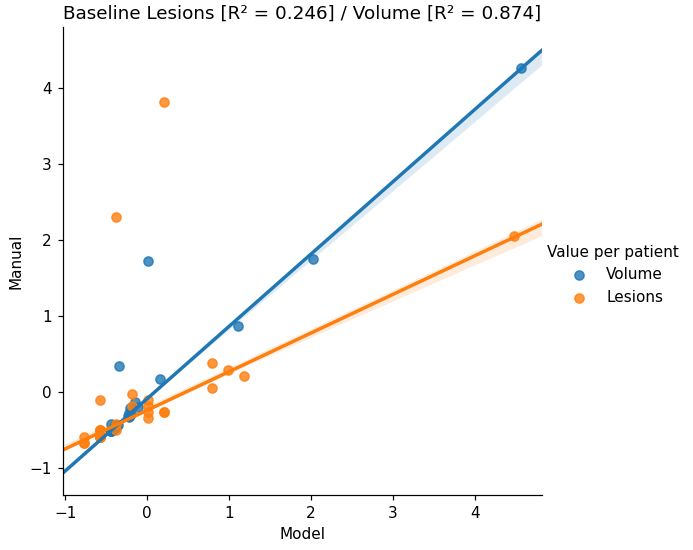

<IPython.core.display.Javascript object>


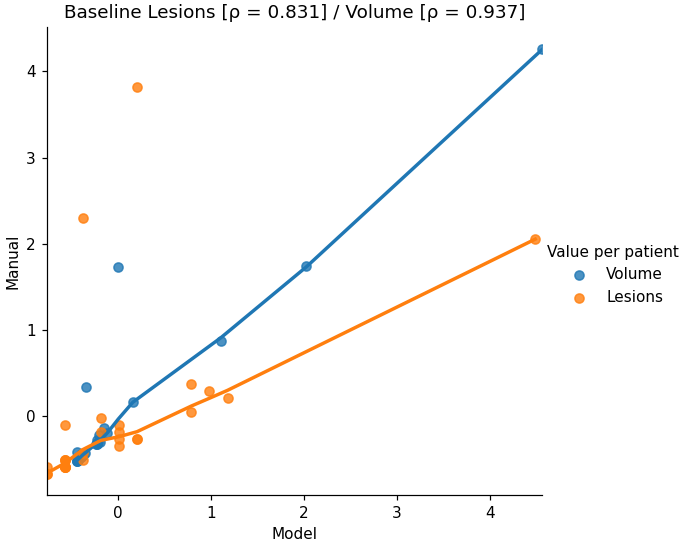

<IPython.core.display.Javascript object>


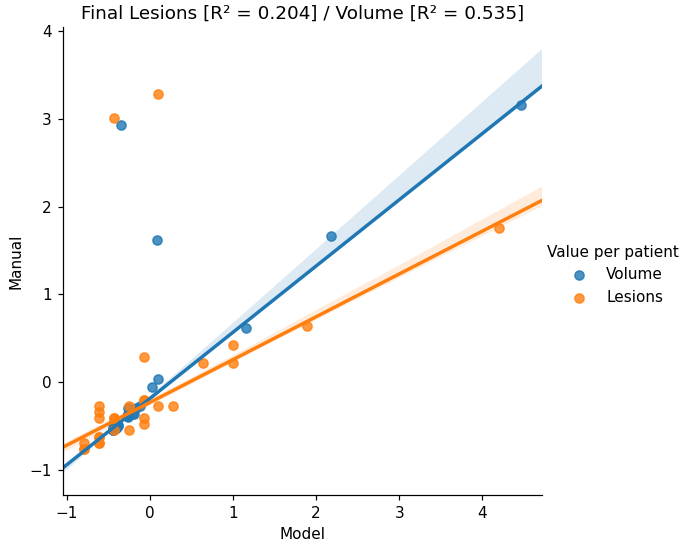

<IPython.core.display.Javascript object>


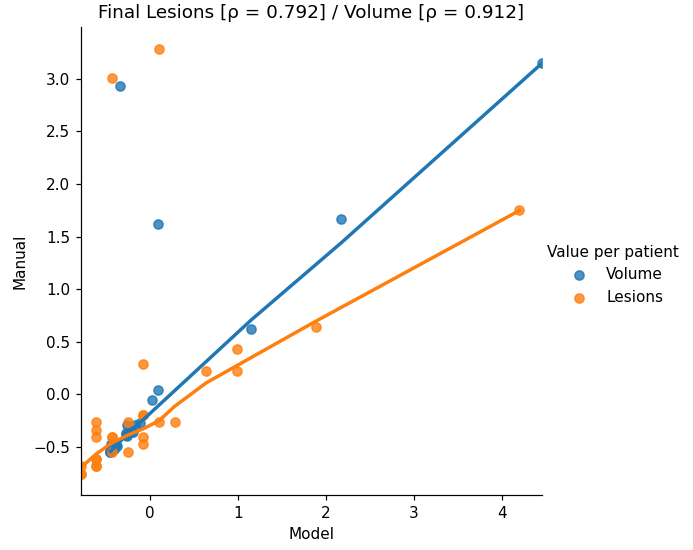

In [21]:
plot_correlation(all_metrics, 'Baseline')
plot_correlation(all_metrics, 'Baseline', lowess=True)
plot_correlation(all_metrics, 'Final')
plot_correlation(all_metrics, 'Final', lowess=True)
# plot_correlation(all_metrics, 'Fine-tuning')
# plot_correlation(all_metrics, 'Fine-tuning', lowess=True)
# plot_correlation(all_metrics, 'Fine-tuning (frozen)')
# plot_correlation(all_metrics, 'Fine-tuning (frozen)', lowess=True)
# plot_correlation(all_metrics, 'Trained')
# plot_correlation(all_metrics, 'Trained', lowess=True)
# plot_correlation(all_metrics, 'Pretrained (private)')
# plot_correlation(all_metrics, 'Pretrained (private)', lowess=True)
# plot_correlation(all_metrics, 'Pretrained')
# plot_correlation(all_metrics, 'Pretrained', lowess=True)